In [32]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix
import itertools

In [33]:
train_dataset = torchvision.datasets.FashionMNIST(root='.',
                                                  train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)

In [34]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [35]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [36]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [37]:
test_dataset = torchvision.datasets.FashionMNIST(root='.',
                                                 train=False,
                                                 transform=transforms.ToTensor(),
                                                 download=True)

In [38]:
# number of classes
K = len(set(train_dataset.targets.numpy()))
print("number of classes:", K)

number of classes: 10


In [39]:
# Define the model
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
                                            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
                                            nn.ReLU()
                                        )
        # http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html
        # "No zero padding, non-unit strides"
        # https://pytorch.org/docs/stable/nn.html
        self.dense_layers = nn.Sequential(
                                            nn.Dropout(0.2),
                                            # Pytorch does not automatically calculates input dimension
                                            nn.Linear(128 * 2 * 2, 512),
                                            nn.ReLU(),
                                            nn.Dropout(0.2),
                                            nn.Linear(512, K)
                                         )

    def forward(self, X):
        out = self.conv_layers(X)
        # flatten the 2D array using veiw function
        # -1 would automatcially computes dimension from the remaining dimensions
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

In [40]:
# Instantiate the model
model = CNN(K)

In [41]:
# The same model! Using the newly introduced "Flatten"
# model = nn.Sequential(
    #     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
    #     nn.ReLU(),
    #     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
    #     nn.ReLU(),
    #     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
    #     nn.ReLU(),
    #     nn.Flatten(),
    #     nn.Dropout(0.2),
    #     nn.Linear(128 * 2 * 2, 512),
    #     nn.ReLU(),
    #     nn.Dropout(0.2),
    #     nn.Linear(512, K)   
    # )

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [43]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [44]:
# Data loader
# Useful because it automatically generates batches in the training loop
# and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [45]:
help(model.train)

Help on method train in module torch.nn.modules.module:

train(mode: bool = True) -> ~T method of __main__.CNN instance
    Sets the module in training mode.
    
    This has any effect only on certain modules. See documentations of
    particular modules for details of their behaviors in training/evaluation
    mode, if they are affected, e.g. :class:`Dropout`, :class:`BatchNorm`,
    etc.
    
    Args:
        mode (bool): whether to set training mode (``True``) or evaluation
                     mode (``False``). Default: ``True``.
    
    Returns:
        Module: self



In [46]:
help(model.eval)

Help on method eval in module torch.nn.modules.module:

eval() -> ~T method of __main__.CNN instance
    Sets the module in evaluation mode.
    
    This has any effect only on certain modules. See documentations of
    particular modules for details of their behaviors in training/evaluation
    mode, if they are affected, e.g. :class:`Dropout`, :class:`BatchNorm`,
    etc.
    
    This is equivalent with :meth:`self.train(False) <torch.nn.Module.train>`.
    
    Returns:
        Module: self



In [47]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    # storing batch losses
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        # Sets the module in training mode.
        model.train()
        t0 = datetime.now()
        
        # epoch losses
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading

        # Sets the module in evaluation mode
        model.eval()
        
        # batch loss
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
  
    return train_losses, test_losses

In [48]:
train_losses, test_losses = batch_gd( model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 0.6588, Test Loss: 0.4907, Duration: 0:00:06.196962
Epoch 2/15, Train Loss: 0.4481, Test Loss: 0.4160, Duration: 0:00:06.136062
Epoch 3/15, Train Loss: 0.3885, Test Loss: 0.3873, Duration: 0:00:06.140536
Epoch 4/15, Train Loss: 0.3535, Test Loss: 0.3506, Duration: 0:00:06.164060
Epoch 5/15, Train Loss: 0.3231, Test Loss: 0.3249, Duration: 0:00:06.190724
Epoch 6/15, Train Loss: 0.3021, Test Loss: 0.3230, Duration: 0:00:06.102831
Epoch 7/15, Train Loss: 0.2843, Test Loss: 0.3133, Duration: 0:00:06.140324
Epoch 8/15, Train Loss: 0.2679, Test Loss: 0.3038, Duration: 0:00:06.147176
Epoch 9/15, Train Loss: 0.2530, Test Loss: 0.3143, Duration: 0:00:06.157664
Epoch 10/15, Train Loss: 0.2376, Test Loss: 0.3018, Duration: 0:00:06.174331
Epoch 11/15, Train Loss: 0.2254, Test Loss: 0.2926, Duration: 0:00:06.167100
Epoch 12/15, Train Loss: 0.2102, Test Loss: 0.3046, Duration: 0:00:06.153115
Epoch 13/15, Train Loss: 0.2013, Test Loss: 0.2940, Duration: 0:00:06.194774
Epoch 14

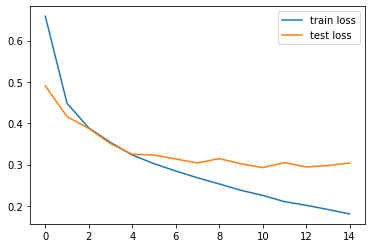

In [49]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [50]:
# Accuracy

# set model in evaluation mode
model.eval()
n_correct = 0.
n_total = 0.

for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9473, Test acc: 0.8985


In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

#   print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization


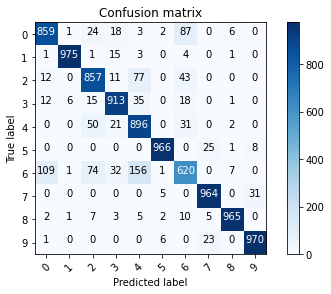

In [52]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    _, predictions = torch.max(outputs, 1)

    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [53]:
# Label mapping
labels = '''T-shirt/top
            Trouser
            Pullover
            Dress
            Coat
            Sandal
            Shirt
            Sneaker
            Bag
            Ankle boot'''.split("\n")

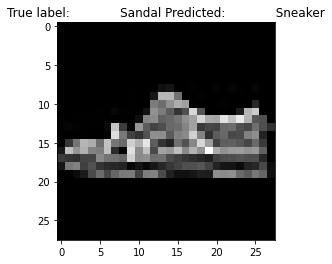

In [54]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));